# 320to335 (15-30 November)

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

from catboost import Pool, CatBoostRegressor, cv 
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('T:\\COVID19\\Makrodaten\\Nov15-30woPe deaths.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_leth_AGS_320to335']
X = df.loc[:, ~df.columns.isin(['std_leth_AGS_320to335'])]
f_names = list(X.columns)
print("Number of features: ", len(X.columns))

Number of features:  155


# First CatBoost Model with 155 features

In [4]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of final model on all data: ",cb.score(X, Y))

R2 of final model on all data:  0.998978536278044


In [5]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  0.25147237968290687


# SHAP VAlues

In [6]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

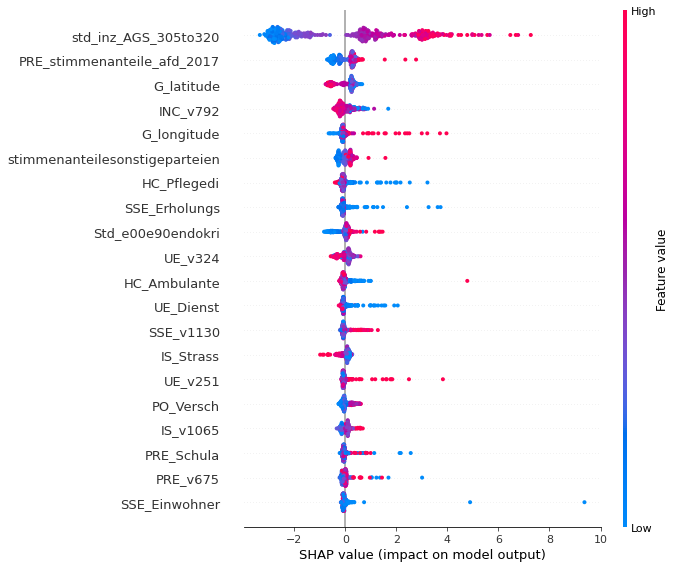

In [7]:
shap.summary_plot(shap_values_cb,X)

# Second CatBoost model with 20 most important features

In [8]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [9]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of second model with top20 feature: ",cb_20.score(X[top20feature], Y))

R2 of second model with top20 feature:  0.9948785074631046


In [10]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  0.5630890605790876


# Compare top 10 features of both Models

In [11]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['std_inz_AGS_305to320', 'PRE_stimmenanteile_afd_2017', 'G_latitude', 'INC_v792', 'G_longitude', 'stimmenanteilesonstigeparteien', 'HC_Pflegedi', 'SSE_Erholungs', 'Std_e00e90endokri', 'UE_v324'] 

 10 most important features from model with top20 features: 
 ['std_inz_AGS_305to320', 'G_latitude', 'INC_v792', 'SSE_Erholungs', 'PRE_stimmenanteile_afd_2017', 'stimmenanteilesonstigeparteien', 'G_longitude', 'HC_Ambulante', 'UE_v251', 'SSE_v1130']


In [12]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

std_inz_AGS_305to320
PRE_stimmenanteile_afd_2017
G_latitude
INC_v792
G_longitude
stimmenanteilesonstigeparteien
SSE_Erholungs


ABS_SHAP(shap_values_cb_20,X[top20feature]) 

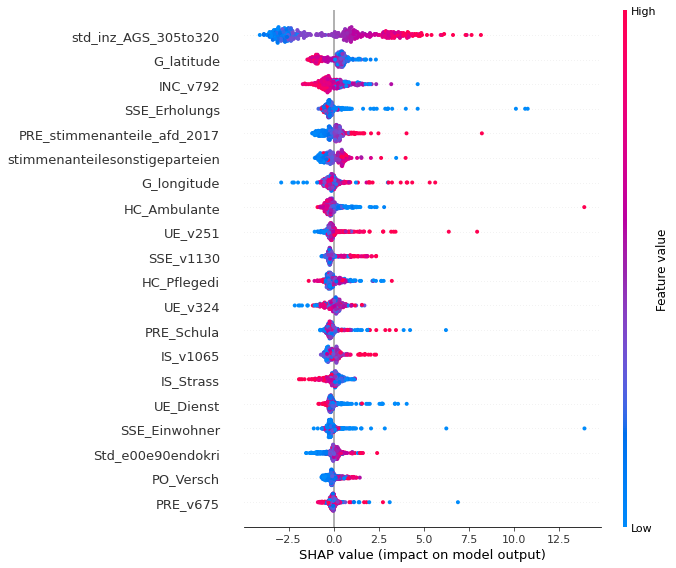

In [13]:
shap.summary_plot(shap_values_cb_20,X[top20feature])

# Hold out validation of the second model

In [14]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [15]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.997011773194691
Mean R2 of linReg_modesl with top20 features:  0.33188765363974365
Mean RMSE of CatBoost_models on test sets with top20 features:  6.289698882310599
Mean R2 of CatBoost_models on test sets with top20 features: 0.2819986779648727


# descriptives of top20 features

In [16]:
X[top20feature].describe()

,std_inz_AGS_305to320,PRE_stimmenanteile_afd_2017,G_latitude,INC_v792,G_longitude,stimmenanteilesonstigeparteien,HC_Pflegedi,SSE_Erholungs,Std_e00e90endokri,UE_v324,HC_Ambulante,UE_Dienst,SSE_v1130,IS_Strass,UE_v251,PO_Versch,IS_v1065,PRE_Schula,PRE_v675,SSE_Einwohner
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,294.754181,13.388280,50.615307,3039.725586,9.866997,5.217952,47.096771,70.509460,64.049629,1.128679,23.816227,39.242905,-86.781769,491.092896,31.871569,1682.694702,21.925186,6.557357,16.566591,490.633423
std,132.152008,5.329521,1.740311,1074.388306,2.026269,1.823041,18.698227,56.734703,15.094089,5.361213,5.234064,14.842251,6.361413,87.669556,11.464511,1549.749634,15.378860,2.242231,5.035091,677.718445
min,51.452923,4.900000,47.500000,27.000000,6.083333,2.000000,13.300000,14.000000,0.000000,-27.200001,0.000000,15.800000,-93.599998,275.799988,0.000000,0.000000,0.000000,2.100000,6.900000,1.000000
25%,187.580597,9.800000,49.283333,2714.000000,8.216666,3.800000,34.000000,39.700001,54.863358,-1.700000,20.100000,29.600000,-88.199997,431.399994,24.400000,649.700012,13.000000,4.900000,13.000000,112.000000
50%,295.148651,12.000000,50.549999,3151.000000,9.766666,4.700000,43.599998,52.799999,63.261333,1.200000,23.799999,33.900002,-87.500000,476.399994,31.700001,1167.900024,21.000000,6.300000,16.100000,187.000000
75%,375.239899,15.300000,51.849998,3554.000000,11.416667,6.600000,57.700001,76.699997,72.358131,4.700000,27.200001,43.099998,-86.500000,545.000000,40.500000,2247.600098,32.000000,8.000000,19.700001,534.000000
max,734.390442,35.500000,54.783333,5974.000000,14.983334,12.600000,136.500000,384.600006,112.477448,20.799999,44.400002,96.599998,0.000000,803.599976,61.900002,9908.299805,79.000000,16.700001,38.000000,4686.000000


In [17]:
pd.DataFrame(Y).describe()

,std_leth_AGS_320to335
count,401.000000
mean,7.961386
std,7.878089
min,0.000000
25%,3.022536
50%,6.109943
75%,10.702458
max,64.755959
